## 해야할 일

1. 시뮬레이션에서 a1,과 b1의 값이 어떻게 나오는지 확인하고 분석하기.
2. 분포를 그려서 시뮬레이션 확인해보기

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from parfor import parfor
from tqdm.notebook import tqdm

In [2]:
@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2
    H2 = Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag,db1.real,db1.imag,da2.real,da2.imag,db2.real,db2.imag])


def to_complex(Zs):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs.T
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    return a1,b1,a2,b2

In [3]:
t = np.arange(0,50_000,0.1)
eta1 = 0.1
eta2 = 0.05

A1 = 1
A2 = np.sqrt(0.6)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)
betas = np.linspace(0,1,51)[1:]
alphas = np.linspace(0,np.pi/2,50,endpoint=False)

In [6]:
alpha = alphas[-5]
@parfor(betas,args=(alpha,eta1,eta2),bar=False)
def get_QR_long(beta,alpha,eta1,eta2):
    Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
    a1s,b1s,a2s,b2s = to_complex(Zs[-10000::50])
    RZ1s = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
    QZ1s = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)

    RZ2s = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
    QZ2s = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)
    return RZ1s,QZ1s,RZ2s,QZ2s,a1s,b1s,a2s,b2s

RZ1,QZ1,RZ2,QZ2,a1s,b1s,a2s,b2s = map(np.array,zip(*get_QR_long))

In [7]:
R1s = np.abs(RZ1)
R2s = np.abs(RZ2)
Q1s = np.abs(QZ1)
Q2s = np.abs(QZ2)

In [8]:
a1s,b1s,a2s,b2s = map(np.array,[a1s,b1s,a2s,b2s])

In [9]:
def dist_ab(x,a,b,eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (1/2+eta/2)*(a_+a_.conjugate())+(1/2-eta/2)*(b_+b_.conjugate()))# + np.conj(c_))
    return f


In [13]:
x =  np.linspace(0,2*np.pi,1000) + 1e-10

In [14]:
plt.plot(x,dist_ab(x,a1s[21][i*50],b1s[21][i*50],eta2),color='red')


IndexError: index 9950 is out of bounds for axis 0 with size 200

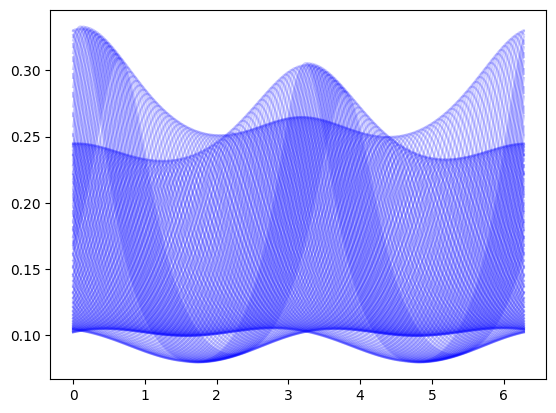

In [23]:
# plt.plot(x,dist_ab(x,a1s[22][-1],b1s[22][-1],eta1))
index = 28
for i in range(150):
    # plt.plot(x,dist_ab(x,a1s[21][i*50],b1s[21][i*50],eta2),color='red')

    plt.plot(x,dist_ab(x-np.angle(a1s[index][i]),a2s[index][i],b2s[index][i],eta2),color='blue',alpha=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


 ...]

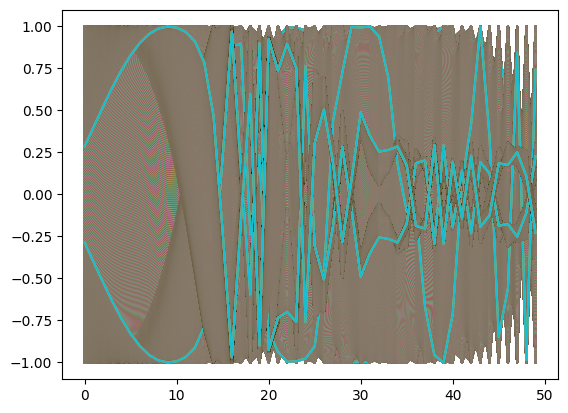

In [59]:
plt.plot(a1s[:,])
plt.plot(b1s[:,])
plt.plot(a2s[:,])
plt.plot(b2s[:,])

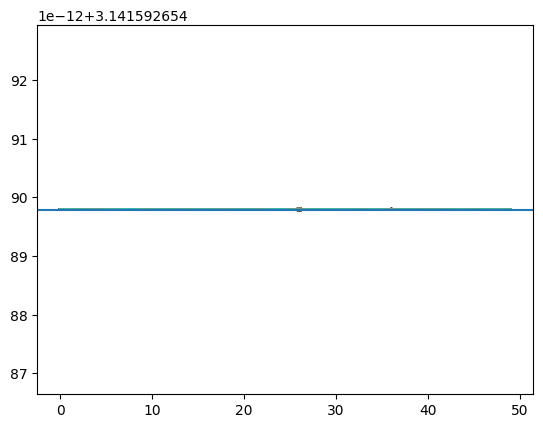

In [60]:
plt.plot(np.abs(np.angle(a1s[:,])-np.angle(b1s[:,])))
plt.axhline(np.pi)

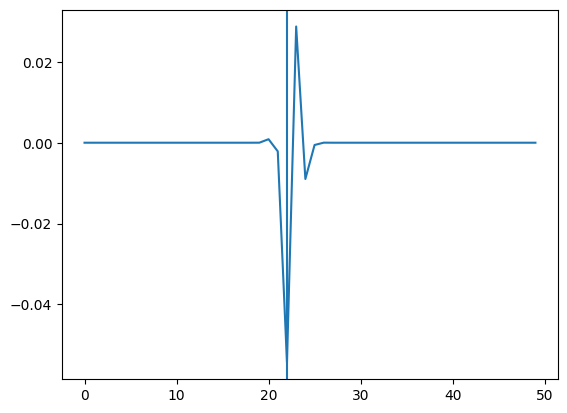

In [201]:
plt.plot(np.abs(np.angle(a2s[:,-1])-np.angle(b2s[:,-1]))- np.pi)
# plt.axhline(np.pi)
plt.axvline(22)

In [149]:
Q2s.shape

(50, 5000)

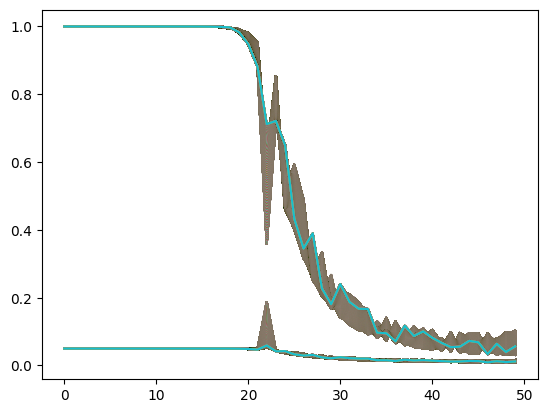

In [153]:
plt.plot(Q2s[:,-5000:]);
plt.plot(R2s[:,-5000:]);

order parameter  R 에서 $\eta_2$의 값이 안나타는 이유는 peak를 나타내는 a2s,a1s의 값들이 1값을 가지지 않기 때문 

In [156]:
t = np.arange(0,50_000,0.1)
eta1 = 0.1
eta2 = 0.05

A1 = 1
A2 = np.sqrt(0.6)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)
betas = np.linspace(0,1,51)[1:]
alphas = np.linspace(0,np.pi/2,50,endpoint=False)

In [157]:

shift = 0.*np.pi
a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1j)
b2 =  a2* np.exp(np.pi*1j)


Q1s,Q2s,R1s,R2s = [],[],[],[]
P1_D,P2_D,A1_D,A2_D = [],[],[],[]
for alpha in tqdm(alphas):
    @parfor(betas,args=(alpha,eta1,eta2),bar=False)
    def get_QR(beta,alpha,eta1,eta2):
        Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))
        a1s,b1s,a2s,b2s = to_complex(Zs[-1])
        P1_diff = np.abs(a1s) -  np.abs(b1s)
        P2_diff = np.abs(a2s) -  np.abs(b2s)
        A1_diff = np.abs(np.angle(a1s) -  np.angle(b1s)) - np.pi
        A2_diff = np.abs(np.angle(a2s) -  np.angle(b2s)) - np.pi

        RZ1s = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
        QZ1s = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)

        RZ2s = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
        QZ2s = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)
        Q1 = np.abs(QZ1s)
        Q2 = np.abs(QZ2s)
        R1 = np.abs(RZ1s)
        R2 = np.abs(RZ2s)
        return Q1,Q2,R1,R2,P1_diff,P2_diff,A1_diff,A2_diff
    Q1,Q2,R1,R2,P1_diff,P2_diff,A1_diff,A2_diff = zip(*get_QR)
    Q1s.append(Q1)
    Q2s.append(Q2)
    R1s.append(R1)
    R2s.append(R2)
    P1_D.append(P1_diff)
    P2_D.append(P2_diff)
    A1_D.append(A1_diff)
    A2_D.append(A2_diff)
Q1s = np.array(Q1s).T
Q2s = np.array(Q2s).T
R1s = np.array(R1s).T
R2s = np.array(R2s).T

P1_D = np.array(P1_D).T
P2_D = np.array(P2_D).T
A1_D = np.array(A1_D).T
A2_D = np.array(A2_D).T

  0%|          | 0/50 [00:00<?, ?it/s]

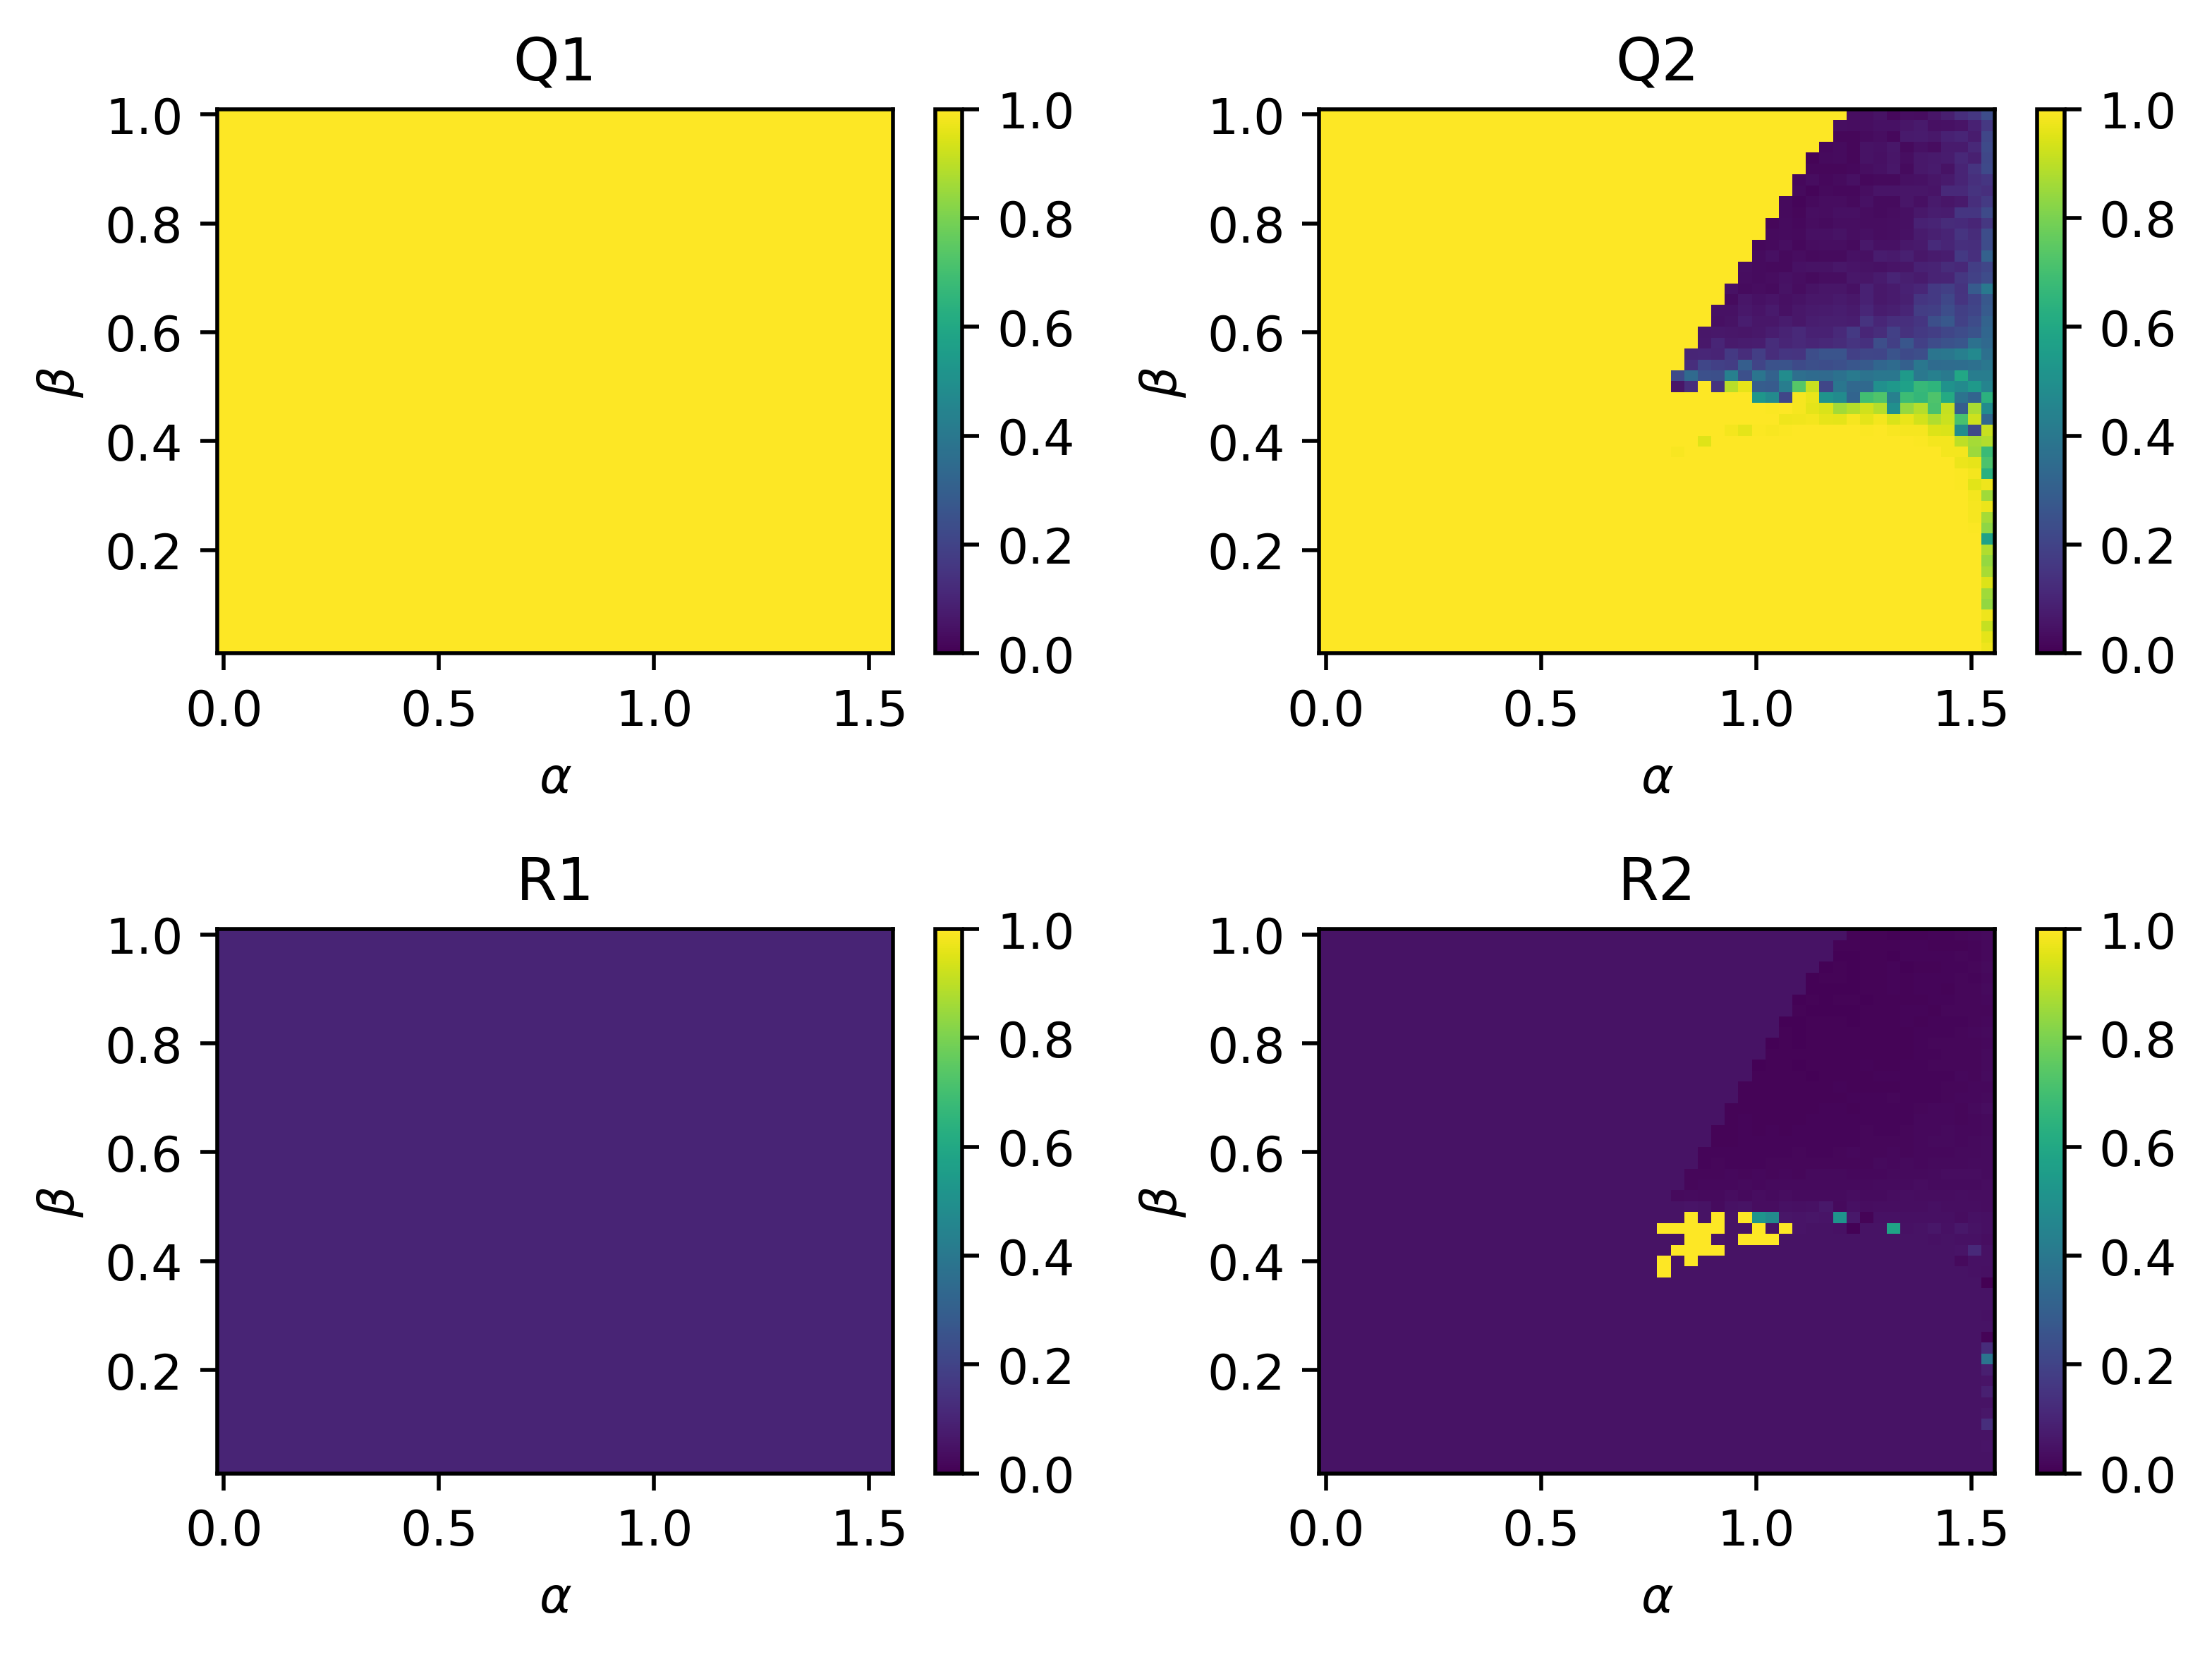

In [162]:
axs = []
fig,axs = plt.subplots(2,2,dpi=500)
((ax1,ax2),(ax3,ax4)) =  axs
# ((ax1,ax2),(ax1_1,ax2_1),(ax3,ax4)) =  axs
plt.sca(ax1)
plt.pcolormesh(alphas,betas,Q1s,vmin=0.0, vmax=1)
plt.colorbar(shrink=1)
plt.title('Q1')

plt.sca(ax2)
plt.pcolormesh(alphas,betas,Q2s,vmin=0.0, vmax=1.0)
plt.colorbar(shrink=1)
plt.title('Q2')


# plt.sca(ax1_1)
# plt.pcolormesh(alphas,betas,Q1_stds,vmin=0,vmax=0.1)
# plt.colorbar(shrink=1)
# plt.title(r'$\sigma_{Q1}$')

# plt.sca(ax2_1)
# plt.pcolormesh(alphas,betas,Q2_stds,vmin=0,)
# plt.colorbar(shrink=1)
# plt.title(r'$\sigma_{Q2}$')


plt.sca(ax3)
plt.pcolormesh(alphas,betas,R1s,vmin=0, vmax=1)
plt.colorbar(shrink=1)
plt.title('R1')

plt.sca(ax4)
plt.pcolormesh(alphas,betas,R2s,vmin=0, vmax=1)
plt.colorbar(shrink=1)
plt.title('R2')


for ax in axs.flatten():
    ax.set_ylabel(r'$\beta$')
    ax.set_xlabel(r'$\alpha$')


plt.tight_layout()


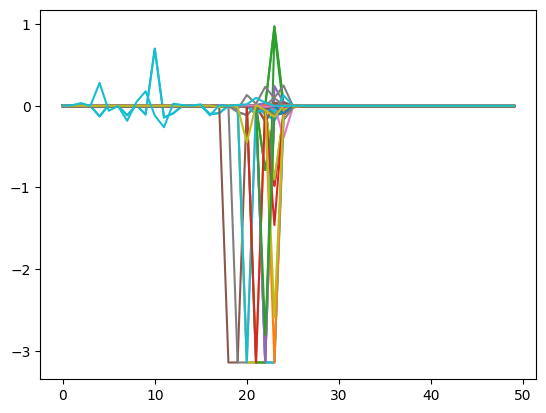

In [163]:
plt.plot(P2_D)
plt.plot(P2_D)
plt.plot(A2_D)


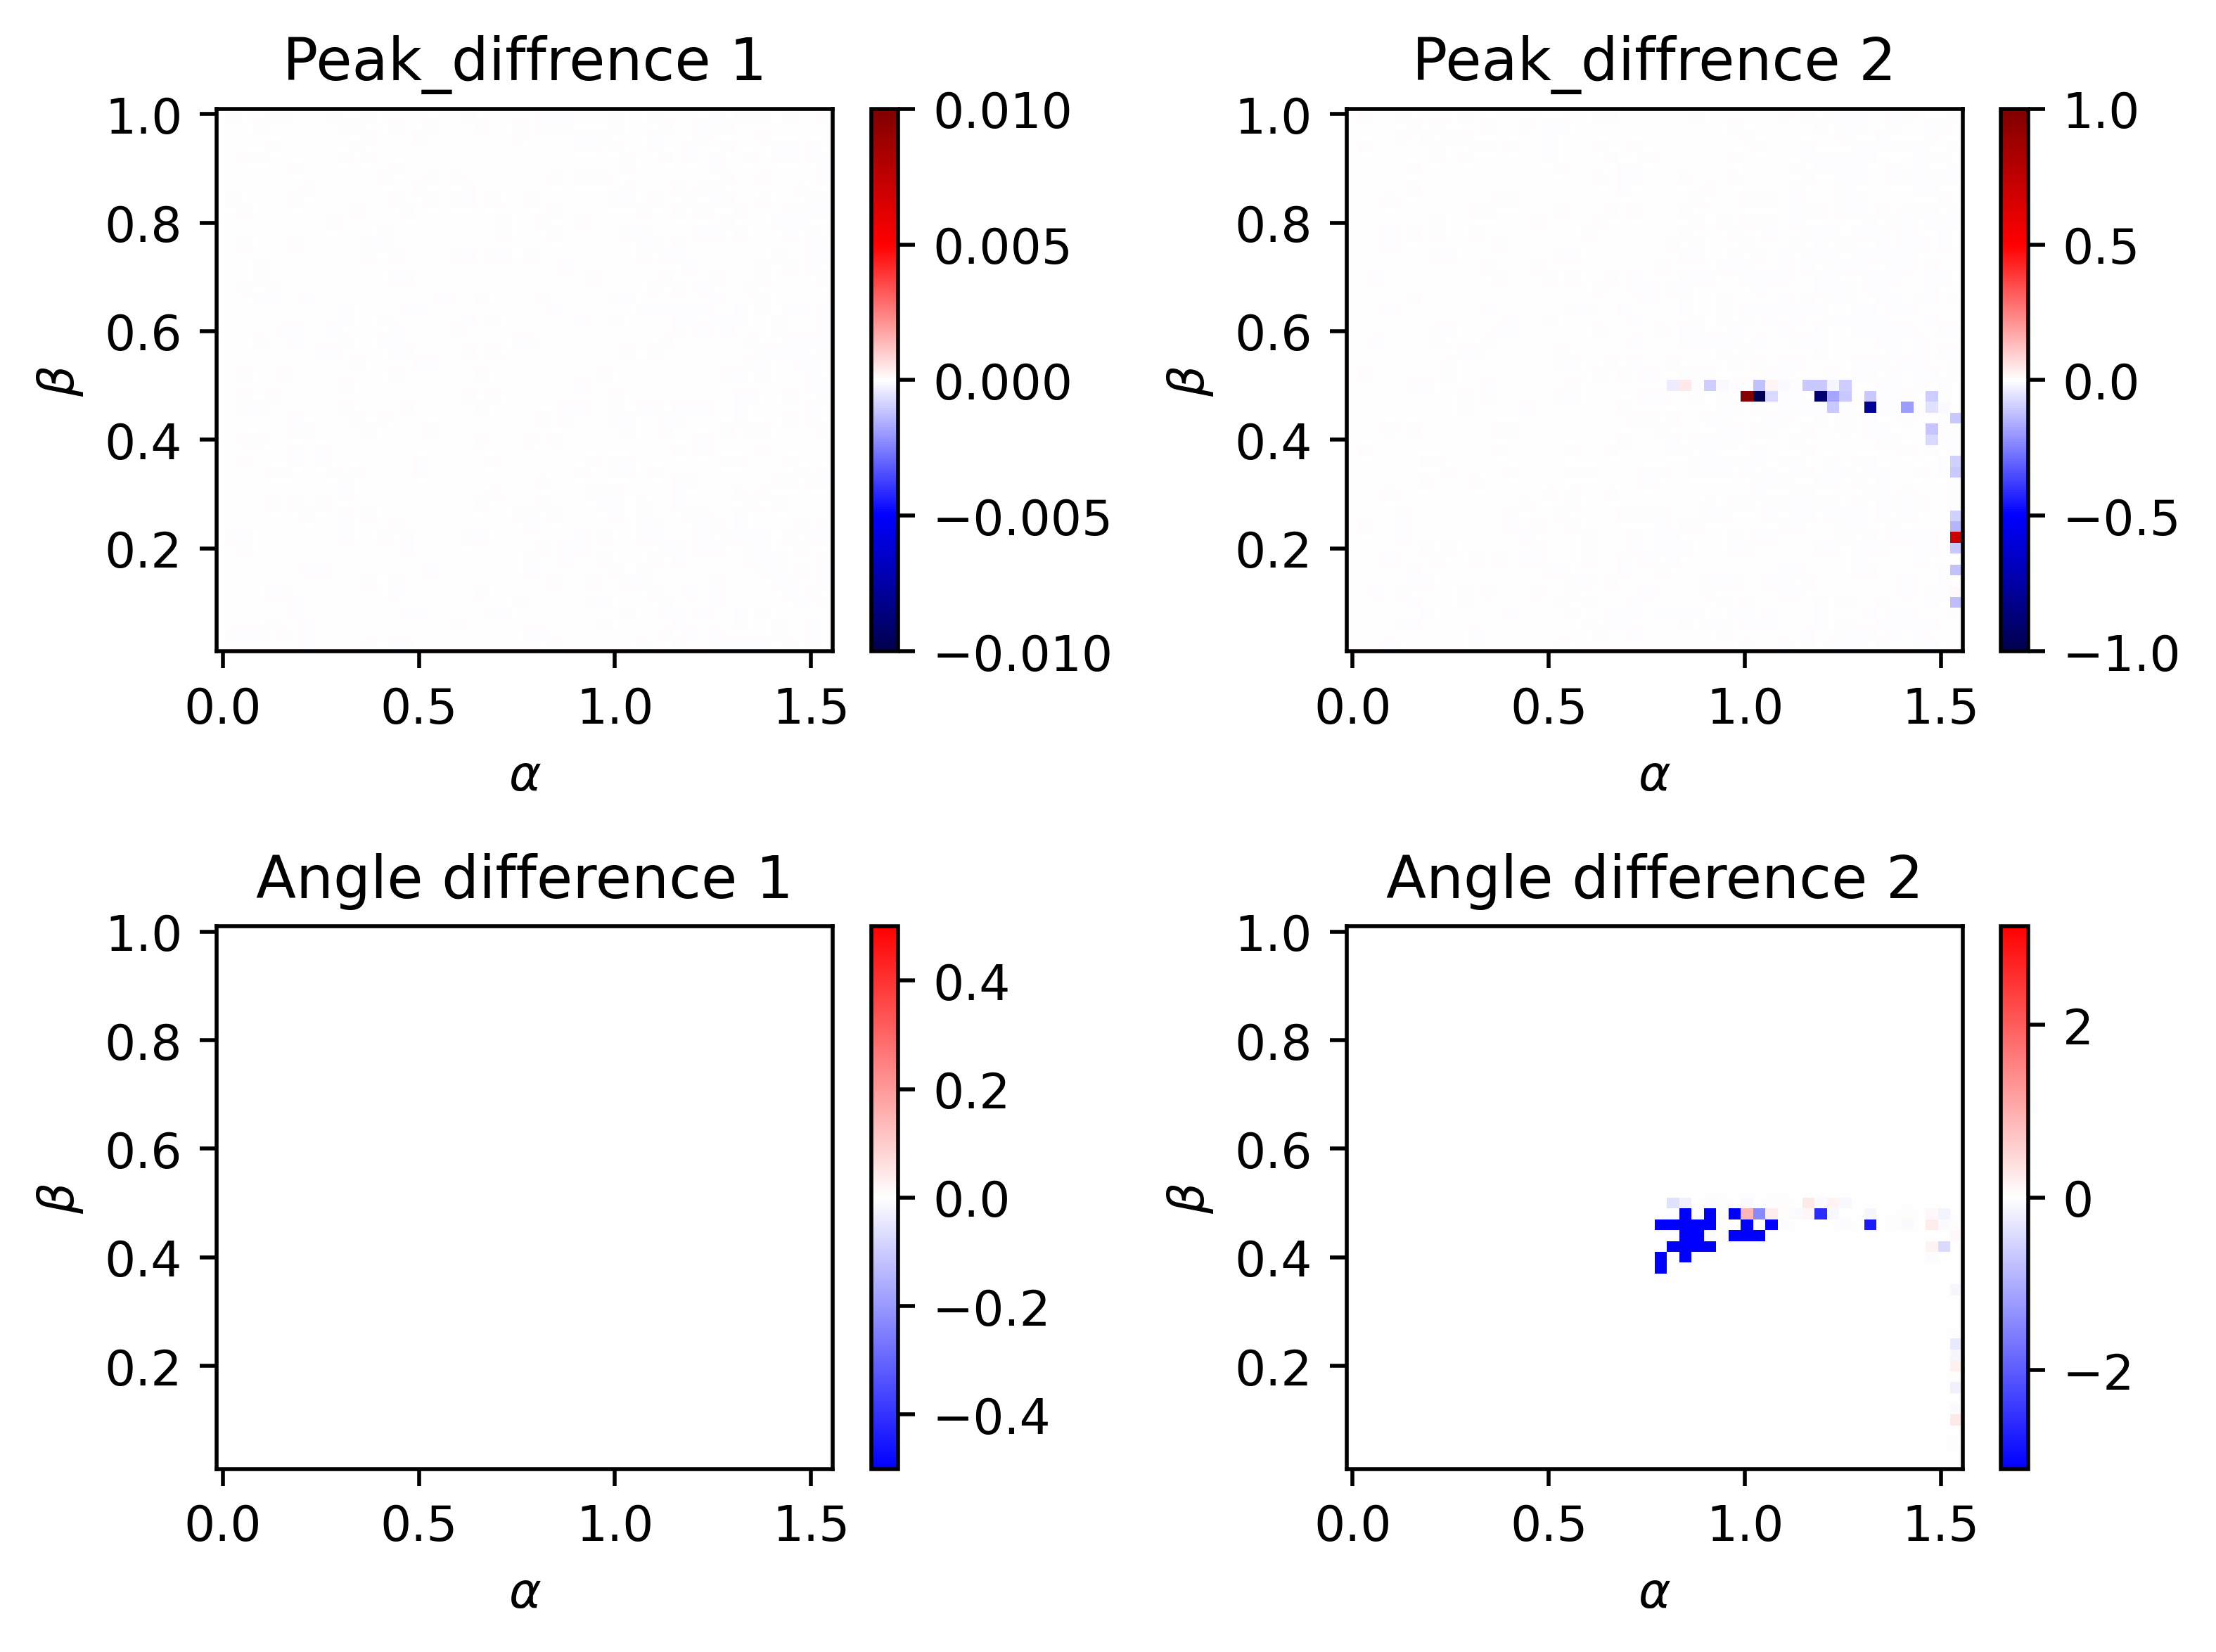

In [166]:
axs = []
fig,axs = plt.subplots(2,2,dpi=500)
((ax1,ax2),(ax3,ax4)) =  axs
# ((ax1,ax2),(ax1_1,ax2_1),(ax3,ax4)) =  axs
plt.sca(ax1)
plt.pcolormesh(alphas,betas,P1_D,vmin=-0.01, vmax=0.01,cmap= 'seismic')
plt.colorbar(shrink=1)
plt.title('Peak_diffrence 1')

plt.sca(ax2)
plt.pcolormesh(alphas,betas,P2_D,vmin=-1, vmax=1,cmap= 'seismic')
plt.colorbar(shrink=1)
plt.title('Peak_diffrence 2')



plt.sca(ax3)
plt.pcolormesh(alphas,betas,A1_D,vmin=-0.5, vmax=0.5,cmap= 'bwr')
plt.colorbar(shrink=1)
plt.title('Angle difference 1')

plt.sca(ax4)
plt.pcolormesh(alphas,betas,A2_D,vmin=-np.pi, vmax=np.pi,cmap= 'bwr')
plt.colorbar(shrink=1)
plt.title('Angle difference 2')


for ax in axs.flatten():
    ax.set_ylabel(r'$\beta$')
    ax.set_xlabel(r'$\alpha$')


plt.tight_layout()


# Solve equation

In [1]:
import sympy as sp

In [54]:
eta1,eta2,r,phi,alpha,beta = sp.symbols('eta1 eta2 r phi alpha beta',real=True)
beta_rp = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)+sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))
beta_rm = eta2*r/(eta1*sp.cos(alpha+2*phi))*(-sp.cos(alpha+phi)-sp.sqrt(sp.cos(alpha+phi)**2-sp.cos(alpha)*sp.cos(alpha+2*phi)))

dr = sp.Rational(1,2) * r* (1-r**2)*(eta2**2 * r**2 * sp.cos(alpha) + 2 * beta*eta1*eta2*r*sp.cos(alpha+phi) + beta **2 *eta1**2 * sp.cos(alpha + 2*phi))
dpsi2 = sp.Rational(1,2) * (1+r**2)*(eta2*r*sp.sin(alpha)+2*beta*eta1*eta2*r*sp.sin(alpha+phi)+beta**2*eta1**2*sp.sin(alpha+2*phi))
dpsi1 = sp.Rational(1,2) * (2)*(eta1*sp.sin(alpha)+2*beta*eta1*eta2*r*sp.sin(alpha-phi)+beta**2*eta2**2*r**2*sp.sin(alpha-2*phi))
dphi = dpsi2 - dpsi1

In [35]:
beta_rp.simplify()

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [62]:
dphi_sim = dphi.subs(beta,beta_rp).simplify()

In [64]:
n,_ = sp.fraction(dphi_sim)

In [147]:
sp.solve(dr,1)[3]#.subs(beta,beta_rp).simplify()

IndexError: list index out of range

In [179]:
def r0_p(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    return r0

def r0_m(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)-np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    return r0
def phi0_p(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def phi0_m(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)-np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    


def phi0_p(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.abs(np.sin(phi))) / (eta2*np.cos(alpha))
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def phi0_0(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = 0
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def phi0_p1(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = 1
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi  

def phi0_m1(phi,alpha,beta,eta1,eta2):
    # eta1 delta peak의 분포 차
    r0 = -1
    dpsi2 = 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi  

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [181]:
phi = np.linspace(0,2*np.pi,10000)
alpha = np.pi - 0.3
beta = 0.9
eta1 = 0.1
eta2 = 0.05


In [184]:
root_scalar(phi0_m,args=(alpha,beta,eta1,eta2),bracket=[np.pi/2,np.pi])

      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: 1.977287737267016
         method: brentq

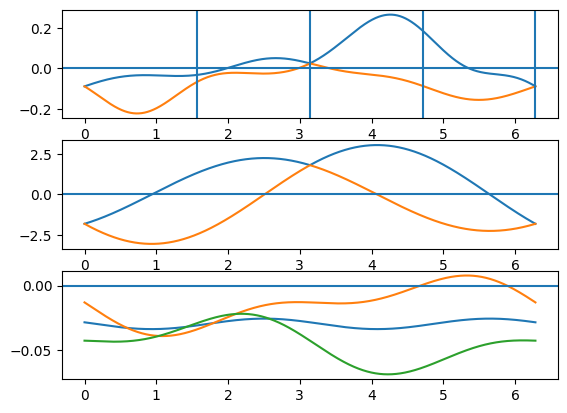

In [186]:
plt.subplot(311)
plt.plot(phi,phi0_m(phi,alpha,beta,eta1,eta2))
plt.plot(phi,phi0_p(phi,alpha,beta,eta1,eta2))
plt.axhline(0)
plt.axvline(np.pi/2)
plt.axvline(np.pi)
plt.axvline(3*np.pi/2)
plt.axvline(4*np.pi/2)
# plt.ylim(-1e-2,1e-2)

plt.subplot(312)
plt.plot(phi,r0_m(phi,alpha,beta,eta1,eta2))
plt.plot(phi,r0_p(phi,alpha,beta,eta1,eta2))
plt.axhline(0)
# plt.ylim(-0.1,1)
plt.subplot(313)
plt.plot(phi,phi0_0(phi,alpha,beta,eta1,eta2))
plt.plot(phi,phi0_p1(phi,alpha,beta,eta1,eta2))
plt.plot(phi,phi0_m1(phi,alpha,beta,eta1,eta2))
plt.axhline(0)




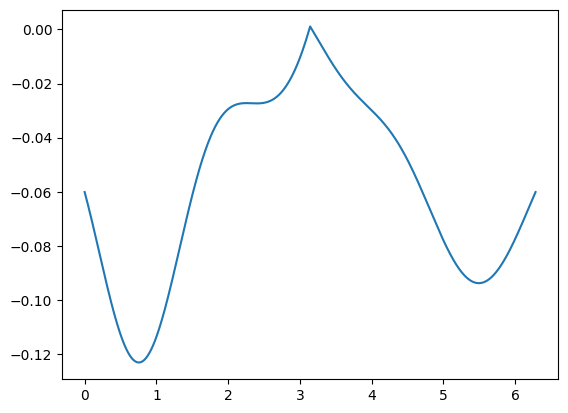

In [123]:
plt.plot(phi,phi0(phi,alpha,beta,eta1,eta2))

In [83]:
dphi.subs(r,1).simplify()

beta**2*eta1**2*sin(alpha + 2*phi) - beta**2*eta2**2*sin(alpha - 2*phi) - 2*beta*eta1*eta2*sin(alpha - phi) + 2*beta*eta1*eta2*sin(alpha + phi) - eta1*sin(alpha) + eta2*sin(alpha)

In [18]:
solve_ = eta2**2*r**2 * sp.cos(alpha) + 2*beta*eta1*eta2*r*sp.cos(alpha+phi) + beta**2*eta1**2*sp.cos(alpha+2*phi)

In [43]:
beta_rp = sp.solve(solve_,beta)[0]#.simplify()
beta_rm = sp.solve(solve_,beta)[1]#.simplify()

In [37]:
sp.solve(solve_,beta)[0]

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [53]:
dphi.subs(beta,beta_rp).simplify()

(-eta1**3*sin(alpha)*cos(alpha + 2*phi)**2 - 2*eta1**2*eta2**2*r**2*(-cos(alpha + phi) + Abs(sin(phi)))*sin(alpha - phi)*cos(alpha + 2*phi) + eta1**2*eta2*r*(r**2 + 1)*(eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))**2*sin(alpha + 2*phi) + 2*eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))*sin(alpha + phi)*cos(alpha + 2*phi) + sin(alpha)*cos(alpha + 2*phi)**2)/2 - eta2**4*r**4*(-cos(alpha + phi) + Abs(sin(phi)))**2*sin(alpha - 2*phi))/(eta1**2*cos(alpha + 2*phi)**2)

In [45]:
beta_rp

eta2*r*(-cos(alpha + phi) + Abs(sin(phi)))/(eta1*cos(alpha + 2*phi))

In [40]:
dr.subs(beta,beta_rp).simplify()


0

In [103]:
drdphi = sp.diff(dr,phi)
drdr   = sp.diff(dr,r)

dphidphi = sp.diff(dphi,phi)
dphidr   = sp.diff(dphi,r)

# drdr = drdr.subs(beta,beta_rm).simplify()
# drdphi = drdphi.subs(beta,beta_rm).simplify()
# dphidr = dphidr.subs(beta,beta_rm).simplify()
# dphidphi = dphidphi.subs(beta,beta_rm).simplify()


In [104]:
J = sp.Matrix([[drdr,drdphi],[dphidr,dphidphi]])

In [102]:
J.det().simplify()

eta2**3*r**3*(-eta1**2*eta2*r**5*sin(phi)**4*sin(alpha + 2*phi)**2 + 3*eta1**2*eta2*r**5*sin(phi)**3*sin(alpha + phi)*cos(alpha + 2*phi) - 3*eta1**2*eta2*r**5*sin(phi)**3*sin(alpha + 2*phi)*cos(alpha + phi) - eta1**2*eta2*r**5*sin(phi)**3*sin(alpha + 2*phi)*Abs(sin(phi)) + 6*eta1**2*eta2*r**5*sin(phi)**2*sin(alpha + phi)*sin(alpha + 2*phi)*cos(alpha + phi)*cos(alpha + 2*phi) + 3*eta1**2*eta2*r**5*sin(phi)**2*sin(alpha + phi)*sin(alpha + 2*phi)*cos(alpha + 2*phi)*Abs(sin(phi)) - 3*eta1**2*eta2*r**5*sin(phi)**2*sin(alpha + 2*phi)**2*cos(alpha + phi)**2 - 3*eta1**2*eta2*r**5*sin(phi)**2*sin(alpha + 2*phi)**2*cos(alpha + phi)*Abs(sin(phi)) - eta1**2*eta2*r**5*sin(phi)**2*cos(2*phi)*cos(alpha + 2*phi)**2/2 + eta1**2*eta2*r**5*sin(phi)**2*cos(alpha + phi)**2*cos(alpha + 2*phi)**2 + eta1**2*eta2*r**5*sin(phi)**2*cos(alpha + phi)*cos(alpha + 2*phi)**2*Abs(sin(phi)) + eta1**2*eta2*r**5*sin(phi)**2*cos(alpha + 2*phi)**2/2 + 3*eta1**2*eta2*r**5*sin(phi)*sin(alpha + phi)*cos(alpha + phi)**2*cos(al

In [91]:
drdphi.subs(beta,beta_rm).simplify()


eta2**2*r**3*(r**2 - 1)*(sin(phi) + sin(alpha + 2*phi)*Abs(sin(phi)))*(cos(alpha + phi) + Abs(sin(phi)))/cos(alpha + 2*phi)**2